<a href="https://colab.research.google.com/github/dsercam/mold-inspired/blob/main/Mold_Network_Entrega6_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='darkorange'><b> Maestría en Inteligencia Artificial Aplicada </b> </font>
# <font color='darkblue'>Tecnológico de Monterrey</font>

## **Bio-Inspired ML Solutions for Sustainable Urban Development**
## **Mold Slime Inspired Network Modeling**
### **<font color='darkblue'>Model Tunning v1</font>**
### **<font color='darkblue'> - Use of elevation map</font>**
### **<font color='darkblue'> - Fixed convergance on multiple disconnected graphs.</font>**
### **<font color='darkblue'> - Fixed orientatation of graph to match map landscape orientation.</font>**
### _Advisors_:
- Carlos Alberto Villaseñor Padilla
- Andrés Felipe Téllez Crespo

### _Contributors_:
- Dante Rodrigo Serna Camarillo
- Jorge Luis Pedroza Rivera
- Axel Alejandro Tlatoa Villavicencio


# <font color='darkorange'> Context </font>

- This collab file contains a second POC of a model inspired by the mold slime growth behavior. This notebook covers a basic implementation of the equation described at the paper Rules for [Biologically Inspired Adaptive Network Design (2010)](https://www.researchgate.net/publication/41111573_Rules_for_Biologically_Inspired_Adaptive_Network_Design).
As part of this incremental POC, the code has now been updated to work with an elevation map, which also help us determine a _restricted area_ for the mold growth.

- Most papers and research being used as references for this idea are related to the *Physarum polycephalum* a type of slime mold, being an unicellular, multi-nucleated organism. This _Amoeba-like_ organism develops as a massive cell body with an extended network of veins that carry protoplasmic fluid to distribute nutrients and other matter throughout its body. One of the most interesting attributes of the *Physarum polycephalum* is that it reacts to changing environmental conditions by adapting the topology (veins) of its network. It also lacks a central nervous system, through multiple researches, it is believed that its restructuring/adapting property is the result of some local optimization processes.

# <font color='darkblue'> Foundations for the mathematical model - Assigning pressures and conductivities</font>
- The proposed model describes the growth of the mold slime as a _Hagen-Poiseuille_ equation, where the flux can be described as:
</br></br>
$$
Q_{ij} = \frac{D_{ij}(p_i - p_j)}{L_{ij}}
$$
</br></br>
Two important concepets _conductivity_ and _longitude_ of a given edge are relevant for the calculation of an edge weight. Considering that, each edge is initialized with a conducitvity (1.0) by default and a lonngitude (in this calcualted as the distance between points).

# <font color='darkblue'> Necessary imports and installs</font>

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from shapely.geometry import LineString, Polygon, Point
from IPython.display import HTML
import matplotlib.animation as animation
%matplotlib inline
#GDAL to handle elevation maps.
from osgeo import gdal

In [2]:

!apt install gdal-bin
!gdalinfo --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 5,055 kB of archives.
After this operation, 25.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.6.4+dfsg-1~jammy0 [1,027 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.6.4+dfsg-1~jammy0 [561 kB]
Fetched 5,055 kB in 2s (3,246 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 123623 files and direc

# <font color='darkorange'><b> COMMON METHODS DEFINITION </b> <font color='darkorange'>

## <font color='darkpurple'> <b> Method for loading elevation map </b> </font>
- Method parameters:
  - __file_name__ : Refers to the name of the elevation file (include path if necessary)
  - __location_name__ : Refers to the name of the location - is only used to log some informative data
  - __x_left__ : Refers to the left (horizontal) boundary of the map section - in pixels
  - __x_right__ : Refers to the right (horizontal) boundary of the map section - in pixels
  - __y_top__ : Refers to the top (vertical) boundary of the map section - in pixels
  - __y_bottom__ : Refers to the bottom (vertical) boundary of the map section - in pixels

- Method outputs:
  - __elevation_section__ : Image of the elevation map section
  - __workspace_latitude__ : Vertical dimension in pixels
  - __workspace_longitude__ : Horizontal dimension in pixels

- **Note:** This method is prepared to handle elevations maps as presented by the CEM (_Continuo de Elevaciones Mexicano_) initiative - files can be obtained from:
https://www.inegi.org.mx/app/geo2/elevacionesmex/


In [3]:
def load_elevation_map_section(file_name, location_name, x_left, x_right, y_top, y_bottom ):
  elevation_map = gdal.Open(file_name).ReadAsArray()
  print(f'{location_name} - Elevation map size: ', elevation_map.shape) #map size in pixels
  elevation_section = elevation_map[x_left:x_right, y_top:y_bottom]
  print(f'{location_name} - Elevation section size: ', elevation_section.shape) # selected section - map size in pixels
  workspace_latitude  = elevation_section.shape[0]
  workspace_longitude = elevation_section.shape[1]
  return elevation_section, workspace_latitude, workspace_longitude

In [4]:
elevation_map, workspace_latitude, workspace_longitude = load_elevation_map_section('NuevoLeonSection.tif', 'Nuevo Leon', 0, 2500, 100, 3000)

Nuevo Leon - Elevation map size:  (5038, 7381)
Nuevo Leon - Elevation section size:  (2500, 2900)


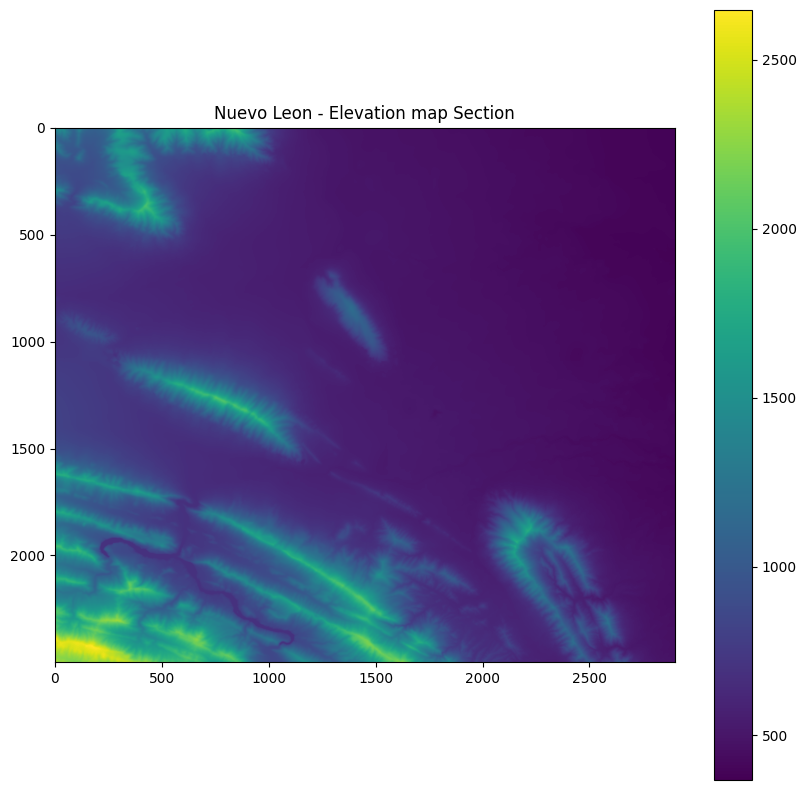

In [5]:
#Render map to validate section
plt.figure(figsize=(10, 10))
plt.imshow(elevation_map) # render our elevation map
plt.title('Nuevo Leon - Elevation map Section')
plt.colorbar()
plt.show()
#Blue areas - lower elevation
#Yellow areas - higher elevation

## <font color='darkpurple'> <b> Method for generation of restriction layer using elevation map </b> </font>
- Method parameters:
  - __elevation_map__ : Elevation map image to generate restriciton mask
  - __restriction_zone__ : Color to be used in the cmap for the restricted regions
  - __goldilocks_zone__ : Color to be used in the cmap for the allowed regions
  - __max_elevation__ : Max elevation to calculate regions
  - __min_elevation__ : Min elevation to calculate regions

- Method outputs:
  - __boolean_map__ : Generated restriction map - (boolean map)
  - __cmap_elevation_mask__ : Cmap for restriction map rendering




In [6]:
# Libraries for image processing
from skimage.morphology import binary_dilation
from skimage import morphology
from skimage.filters import gaussian
import matplotlib.colors

In [28]:
def generate_restriction_boolean_map(elevation_map, restriction_zone = '#F97306', goldilocks_zone = '#FFFFFF00', max_elevation = 750, min_elevation = 300):
  # Define a color map for allowed and restricted areas.
  # First color refers to the allowed/goldilocks zone, second value refers to the restricted area.
  cmap_elevation_mask = matplotlib.colors.ListedColormap([goldilocks_zone, restriction_zone])

  # Define a "goldilocks zone" between elevations
  max_altitude = max_elevation
  min_altitude = min_elevation

  boolean_map = gaussian(elevation_map, sigma=8) #apply gaussian filter to our original elevation map
  boolean_map = (elevation_map < max_altitude)&(elevation_map > min_altitude) # Get outline of terrain within our goldilocks zone
  boolean_map = binary_dilation(boolean_map, morphology.disk(radius=5))
  boolean_map = 1 - binary_dilation(boolean_map, morphology.disk(radius=10))

  fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharex=True, sharey=True)
  ax = axes.ravel()

  ax[0].set_title('Elevation map')
  ax[0].imshow(elevation_map)

  ax[1].set_title('Restriction mask')
  ax[1].imshow(boolean_map, cmap=cmap_elevation_mask)

  ax[2].set_title('Restriction mask over elevation map')
  ax[2].imshow(elevation_map) # render our elevation map
  ax[2].imshow(boolean_map, cmap=cmap_elevation_mask) # render mask over our elevation map

  return boolean_map, cmap_elevation_mask


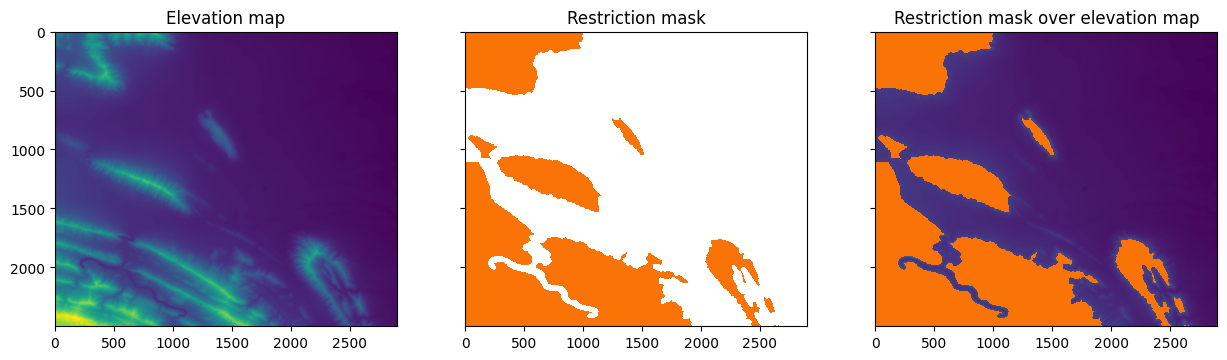

In [29]:
restriction_map, restriction_cmap = generate_restriction_boolean_map(elevation_map)

## <font color='deeppink'> IDEA: define an elevation score using the derivative map </font>
- Use an image derivative to calculate the slope value of a given edge, which could be used as a boosting score or handicap between nodes.

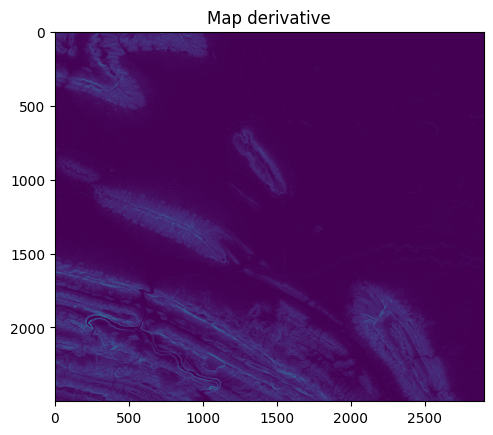

In [ ]:
# Generate a map derivative
from skimage.filters import laplace
from skimage.filters import sobel
dev_map = sobel(nl_elevation_map_section/np.sum(nl_elevation_map_section)) #apply sobel filter to our section of the elevation map
dev_map = dev_map/(np.max(dev_map)-np.min(dev_map)) # generate the elevation map as dev_map

plt.figure()
plt.imshow(dev_map)
plt.title('Map derivative')
plt.show()

TODO: Refine a method that calcualtes a score for the elevation of an edge.

In [ ]:
def score_elevation(dev_map, start, end):

  s = Point(start[0], start[1]) #staring endpoint of edge
  e = Point(end[0], end[1]) # ending enpoint of edge

  rr, cc = line(int(s.x), int(s.y), int(e.x), int(e.y))
  pixels = dev_map[rr, cc]
  return np.max(pixels)


## <font color='darkpurple'> Supporting methods to validate collision with restricted areas.

In [30]:
#import
from skimage.draw import line

# Function contains(boolean_map, point)
# Given a binary map (boolean_map) - determine if a specified point falls within a restricted area.
def contains(boolean_map, point):
  return boolean_map[int(point.x), int(point.y)] #returns true if the point exists in the boolean map (gray area)

#Function line_collision(boolean_map, start, end)
# Function help us determine if an edge - defined as a line between two points, crosses a restricted area
def line_collision(boolean_map, start, end):

  s = Point(start[0], start[1]) #start point
  e = Point(end[0], end[1]) # end point

  # First determine if either the start or end points are in a restricted area, if any of them is, return TRUE immediately
  if contains(boolean_map, s) or contains(boolean_map, e): return True

  # if endpoints are clear, lets determine if any point in the edge between them falls into a restricted area
  rr, cc = line(int(s.x), int(s.y), int(e.x), int(e.y))
  pixels = boolean_map[rr, cc] # pixels in the line matching against pixels on the restricted areas - if any, return true
  if True in pixels:
    return True
  return False



In [31]:
# Function contains(boolean_map, point)
# Given a binary map - determine if a specified point falls within a restricted area.
def contains_point(boolean_map, point):
  return boolean_map[int(point[0]),int(point[1])] #returns true if the point exists in the boolean map (gray area)

#Function line_collision_points(boolean_map, start, end)
# Function help us determine if an edge - defined as a line between two points, crosses a restricted area
def line_collision_points(boolean_map, start_node, end_node, node_positions):

  s = node_positions[start_node] #start point
  e = node_positions[end_node] # end point

  # First determine if either the start or end points are in a restricted area, if any of them is, return TRUE immediately
  if contains_point(boolean_map, s) or contains_point(boolean_map, e): return True

  # if endpoints are clear, lets determine if any point in the edge between them falls into a restricted area
  rr, cc = line(int(s[0]),int(s[1]), int(e[0]),int(e[1]))
  pixels = boolean_map[rr, cc] # pixels in the line matching against pixels on the restricted areas - if any, return true
  if True in pixels:
    return True
  return False


# <font color='darkorange'><b> MODEL v1  </b> <font color='darkorange'>


## <font color='darkpurple'> Methods for base graph defintion </font>
- A node is a point that must be connected by the resulting graph.

- **Note:** when connecting each node to _n_ of its closest neighbours we are affecting the node degree, it appears that this impacts how the weights/conductivities converge. Further experimentaton needed to figure out an appropriate relation between number of nodes and the number of connected neighbours.

- **Note Update:** apparently the issue on covnergance was caused by the graph having multiple disconnected graphs. To address this issue, we will need to apply the model on each disconnected subgraph of the generated graph.


### <font color='darkblue'><b> generate_graph() </b></font>

In [32]:
# Provide the number od desired nodes
# Provide the restriction map (boolean map) - This can be enhanced to support multiple restriction maps
# Provide coordiante limits for nodes generation, minimum and maximum latitude and longitudes.

# Method will return the graph and a dictonary containing the coordinates of each node.

def generate_graph(node_qty, restriction_map, min_lat = 0, max_lat = 0, min_lon = 0, max_lon = 0):
    # Dictionary to hold node # and its position within the workspace
    node_positions = {}
    for node_index in range(node_qty):
        while True:
          x, y = np.random.uniform(min_lat, max_lat), np.random.uniform(min_lon, max_lon) #random point within our workspace dimesnions
          point = Point(x, y)
          # Validate the point does not fall into a restricted area
          #if cleared, assign coordinates to the point, a new set of values will be considered otherwise until condition is fulfilled
          if not (contains(restriction_map, point)):
              node_positions[node_index] = (x, y)
              break  # Exit assignment on valid position

    # Create empty graph.
    G = nx.Graph()
    # add our generated positions to the graph
    G.add_nodes_from(node_positions.keys())

    return G , node_positions

In [34]:
G, node_coordiantes = generate_graph(100, restriction_map, 0, workspace_latitude, 0, workspace_longitude) #mehtod execution without errors

### <font color='darkblue'><b> generate_inverted_postions() </b></font>

- In order to fix the rendering of the graph in the correct lanndscape mode we generate a mirrored version of the positions with this method
- Resulting dictionary is only used for rendering, not for calculations

In [35]:
# Provide the dictionary of network node positions
# Returns another dictionary of inversed network positions

def generate_inverted_positions(node_positions):
  num_nodes = len(node_positions)
  inverse_positions = {}
  for node_id in range(num_nodes):
      x, y = node_positions[node_id]
      inverse_positions[node_id] = (y, x) # switch x,y
  return inverse_positions

In [36]:
inverse_node_positions = generate_inverted_positions(node_coordiantes) # Method executes without issues

### <font color='darkblue'><b> connect_k_closest_nodes() </b></font>



In [37]:
# Provide graph
# Provide node positions
# Define the number of k closest nodes to connect
# Provide restriction map to prevent creation of edges over restricted areas

# This method executes in-place, no objects are returned

def connect_k_closest_nodes(graph, node_positions, k, restriction_map):
  for node in graph.nodes():
    # Calculate distances to other nodes
    distances = []
    for second_node in graph.nodes():
        if second_node != node: #if we are not selecting the same node twice... calculate distance between nodes
            distance = np.hypot(node_positions[node][0] - node_positions[second_node][0],
                                 node_positions[node][1] - node_positions[second_node][1])
            distances.append((second_node, distance))
    # Order by distance and connect to closest nodes
    distances.sort(key=lambda x: x[1])
    neighbours = [n for n, d in distances[:k]]
    for neighbour in neighbours:
        # Generate an edge if the line between two given nodes does not cross a restricted area
        start = node_positions[node]
        end   = node_positions[neighbour]
        if not(line_collision(restriction_map, start, end)):
            if not graph.has_edge(node, neighbour):
                graph.add_edge(node, neighbour)


In [ ]:
connect_k_closest_nodes(G, node_coordiantes, 5, boolean_map) # method executes wihtout issues

## <font color='darkpurple'> Methods for graph attribtues initialization </font>
- Initialize graph conductivity and longitude attributes.

### <font color='darkblue'><b> initialize_conductivity_longitude() </b></font>



In [38]:
# provide graph
# provide node positions

# method executes in-place, no objects or structures are returned

def initialize_conductivity_longitude(graph,postions):
# Initialize conductivity and longitude for each graph edge.
  D = {}
  L = {}
  for edge in graph.edges():
    # Initial conductivity as 1
    D[edge] = 1.0
    # One of the ideas is to boost or set a handicap to a node based on certain attributes, elevation or slope as an example.
    # D[edge] = score_elevation(dev_map, pos_i, pos_j)

    # Calculate longitude for the edge
    pos_i = postions[edge[0]]
    pos_j = postions[edge[1]]
    length = np.hypot(pos_i[0] - pos_j[0], pos_i[1] - pos_j[1])
    L[edge] = length

  # Assing conductivity and longitude to the edges
  nx.set_edge_attributes(graph, D, 'conductivity')
  nx.set_edge_attributes(graph, L, 'length')

In [39]:
initialize_conductivity_longitude(G, node_coordiantes) # method executes without errors

### <font color='darkblue'><b> boost_conductivity_by_elevation() </b></font>
 - This method could be used to set a handicap based on elevation - it is not used in the file yet


In [40]:
def boost_conductivity_by_elevation(graph, postions):
  D = {}
  for edge in graph.edges():
    pos_i = postions[edge[0]]
    pos_j = postions[edge[1]]
    # One of the ideas is to boost or set a handicap to a node based on certain attributes, elevation or slope as an example.
    D[edge] = score_elevation(dev_map, pos_i, pos_j)
  # Assing conductivity
  nx.set_edge_attributes(graph, D, 'conductivity')

## <font color='darkpurple'> Assmeble methods for final graph initialization </font>

### <font color='darkblue'><b> set_working_graph() </b></font>
 - Method that generates the graph, connects its odes and initializes its attributes based on the set of required params for such operations.


In [41]:
# Method returns the connected, initilized graph and the dictionary of normal an inverted positions

def set_working_graph(node_qty, restriction_map, k, min_lat = 0, max_lat = 0, min_lon = 0, max_lon = 0):
  G, coords = generate_graph(node_qty, restriction_map, min_lat, max_lat, min_lon, max_lon)
  connect_k_closest_nodes(G, coords, k, restriction_map)
  initialize_conductivity_longitude(G, coords)
  inverted_pos = generate_inverted_positions(coords)
  return G, coords, inverted_pos

## <font color='darkpurple'> Methods for adgusting pressures and conductivities </font>

### <font color='darkblue'><b> adjust_pressures() </b></font>

In [42]:
# This method adjusts the pressure between a siphon node and a sink node
# PARAMETERS:
# G           -> working graph
# siphon_node -> siphon / source node
# sink_node   -> sink node
# I0          -> Flux intensity

def adjust_pressures(G, siphon_node, sink_node, I0):

    n_nodes = G.number_of_nodes() #get the node qty
    node_list = list(G.nodes())
    node_indexes = {node: idx for idx, node in enumerate(node_list)} #generate an index of all nodes

    # Siphon and sinks vector
    S = np.zeros(n_nodes) # init to zeros
    S[node_indexes[siphon_node]] = I0 # set IO for our siphone node
    S[node_indexes[sink_node]] = -I0  # set -IO for sink node

    # Matriz de conductancias
    C = np.zeros((n_nodes, n_nodes))

    #for each edge..
    for edge in G.edges():
          i = node_indexes[edge[0]]
          j = node_indexes[edge[1]]
          D_ij = G.edges[edge]['conductivity']
          L_ij = G.edges[edge]['length']
          C_ij = D_ij / L_ij
          C[i, j] = -C_ij
          C[j, i] = -C_ij
          C[i, i] += C_ij
          C[j, j] += C_ij

    # Condición de frontera (Set sink node pressure to zero)
    sink_idx = node_indexes[sink_node]
    C_reduced = np.delete(np.delete(C, sink_idx, axis=0), sink_idx, axis=1)
    S_reduced = np.delete(S, sink_idx)

    # Solve the pressure linear system
    try:
        p_reduced = np.linalg.solve(C_reduced, S_reduced)
        #print("solved linear system")
    except np.linalg.LinAlgError:
        #print("failed solving linear system")
        # If matrix is not invertible, set pressures as zero
        p_reduced = np.zeros(n_nodes - 1)

    # Insertar pressure in the sink node
    p = np.insert(p_reduced, sink_idx, 0)
    # Calculate flux in each edge
    Q = {}
    for edge in G.edges():
        i = node_indexes[edge[0]]
        j = node_indexes[edge[1]]
        D_ij = G.edges[edge]['conductivity']
        L_ij = G.edges[edge]['length']
        Q_ij = D_ij * (p[i] - p[j]) / L_ij
        Q[edge] = Q_ij
    #return pressure and edge-flux
    return p, Q

### <font color='darkblue'><b> update_conductivities() </b></font>

In [49]:
# This method updates edge conductivity based on edge flux.
# PARAMETERS:
# G           -> working graph
# Q           -> edge flux
# time_delta  -> time delta
# nl_factor   -> nonlinearity factor

def update_conductivities(G, Q, time_delta, nl_factor, node_positions, restriction_map):
    # Remove invalid/interesecting edges.
    edges_to_remove = []
    for edge in G.edges():
        # Does the edge intersects with an obstacle?
        start = node_positions[edge[0]]
        end = node_positions[edge[1]]
        if (line_collision(restriction_map, end, start)):
            # Line crosses an obstacle, set in the list of edges to remove
            edges_to_remove.append(edge)
        else:
            D_ij = G.edges[edge]['conductivity']
            Q_ij = abs(Q[edge])
            # Sigmoind function
            f_Q = (Q_ij ** nl_factor) / (1.0 + Q_ij ** nl_factor)
            dD_dt = f_Q - D_ij
            #D_new = D_ij + time_delta * dD_dt * D_ij
            D_new = D_ij + time_delta * dD_dt
            # Conductivity must be positive. Avoid cero or negative conductivity.
            G.edges[edge]['conductivity'] = max(D_new, 1e-6)
    # Remove invalid/interesecting edges.
    G.remove_edges_from(edges_to_remove)

## <font color='darkpurple'> Method for model</font>


### <font color='darkblue'><b> run_network_model() </b></font>

In [210]:
def run_network_model(G, positions, inverted_positions, restriction_map, restriction_mask,  IO =1.0, nl_factor = 2.0, time_delta = 0.1, num_iterations = 10, edge_render_weight = 5, render_progress = False):
  conductivity_history = []

  # For the given number of iteartions
  for iteration in range(num_iterations):
      # Randomly select the a siphon and a sink node.
      source_node = random.choice(list(G.nodes())) # Source/siphon node
      sink_node = random.choice(list(G.nodes())) # sink node
      while sink_node == source_node:
          sink_node = random.choice(list(G.nodes()))

      #if not(line_collision_points(boolean_map, source_node, sink_node, node_coordiantes)): # not necessary after fixing convergence, keeping if required later
      # Ajustar las presiones y calcular los flujos
      p, Q = adjust_pressures(G, source_node, sink_node, IO)
      # Actualizar las conductividades
      ##if(not(not np.any(p))):
      update_conductivities(G, Q, time_delta, nl_factor, positions,restriction_map)

      # Almacenar las conductividades para visualización (cada 10 iteraciones)
      if iteration % 10 == 0:
          D_values = [G.edges[edge]['conductivity'] for edge in G.edges()]
          conductivity_history.append(D_values)

      # Visualizar la red cada 20 iteraciones
      if (((iteration + 1) % 100 == 0)) and (render_progress is True):
          plt.figure(figsize=(8, 8))
          # Set edge width based on edge conductivity.
          edge_widths = [G.edges[edge]['conductivity'] * edge_render_weight for edge in G.edges()]  # Factor by N for better visualization

          # Render restricted areas
          plt.imshow(restriction_map, cmap=restriction_mask)
          # Render graph
          nx.draw(G, pos=inverted_positions, node_size=50, width=edge_widths, with_labels=False, edge_color='green')

          plt.title(f'Iteration {iteration + 1}')
          plt.ylim(workspace_latitude,0)
          plt.xlim(0, workspace_longitude)
          plt.show()

      # Información de progreso (opcional)
      if (iteration + 1) % 100 == 0:
          print(f"Iteration {iteration + 1}/{num_iterations} completed.")

  print("Simulation completed.")
  return conductivity_history

In [51]:
def generate_subgraphs(graph):
    subgraphs = []
    subgraphs = [graph.subgraph(c).copy() for c in nx.connected_components(graph)]
    return subgraphs

In [211]:
def run_mold_simulation(G, positions, inverted_positions,  restricted_map, restriction_mask, IO =1.0, nl_factor = 2.0, time_delta = 0.1, num_iterations = 1000, edge_render_weight = 5, render_progress = False):
  ch_sets = []
  subgraphs = generate_subgraphs(G)
  print(f"Generated {len(subgraphs)} subgraphs.",)
  for subgraph in subgraphs:
    if(subgraph.number_of_nodes() > 5):
      print("Starting simulation in subgraph...")
      ch_sets.append(run_network_model(subgraph, positions, inverted_positions,  restricted_map, restriction_mask,  IO, nl_factor, time_delta, num_iterations, edge_render_weight, render_progress))
    else:
      print("Skipping simulation in subgraph - Num Nodes < 5 ...")
      ch_sets.append([])
  return ch_sets, subgraphs

## <font color='darkpurple'> Method for results plotting </font>

In [59]:
def plot_graph(G, inverse_node_positions, restricted_map, restriction_mask, edge_weight, x, y, title):
  plt.figure(figsize=(x, y))
  # Set edge width based on edge conductivity.
  edge_widths = [G.edges[edge]['conductivity'] * edge_weight for edge in G.edges()]  # Factor by N for better visualization

  # Render restricted areas
  plt.imshow(restricted_map, cmap=restriction_map)plot_graph

  # Render graph
  nx.draw(G, pos=inverse_node_positions, node_size=50, width=edge_widths, with_labels=True, edge_color='green')

  plt.title('Conductividades Finales de la Red')
  plt.ylim(0, workspace_latitude)
  plt.xlim(0, workspace_longitude)

  plt.show()

In [62]:
def render_final_network(subgraphs, node_pos, restriction_map, restriction_mask):
  plt.figure(figsize=(10, 10))
  edge_widths = []
  for graph in subgraphs:
    if(graph.number_of_nodes() > 5):
      edge_widths.append([graph.edges[edge]['conductivity'] * 50 for edge in graph.edges()])

  for graph in subgraphs:
    graph_index = 0
    if(graph.number_of_nodes() > 5):
      nx.draw(graph, pos=node_pos, node_size=50, width=edge_widths[graph_index], with_labels=False, edge_color='purple')
    graph_index += 1

  # Render restricted areas
  plt.imshow(restriction_map, cmap=restriction_mask)
  plt.title('Final Conductivity of network')
  plt.ylim(workspace_latitude, 0)
  plt.xlim(0, workspace_longitude)

  plt.show()

# <font color='darkorange'><b> RUN MODEL v1 </b> <font color='darkorange'>
 - Calculate model on each disconnected graph

In [55]:
G2, node_coordiantes2, inverse_node_positions2 = set_working_graph(300, restriction_map,  25, 0, workspace_latitude, 0, workspace_longitude)

Generated 4 subgraphs.
Starting simulation in subgraph...


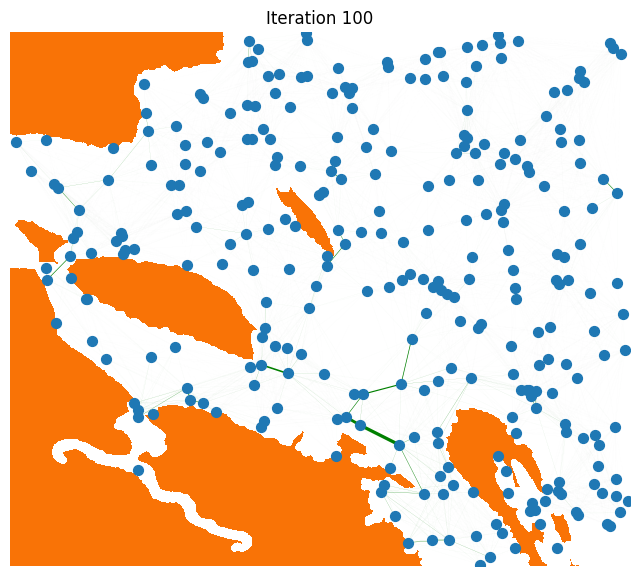

Iteration 100/1000 completed.


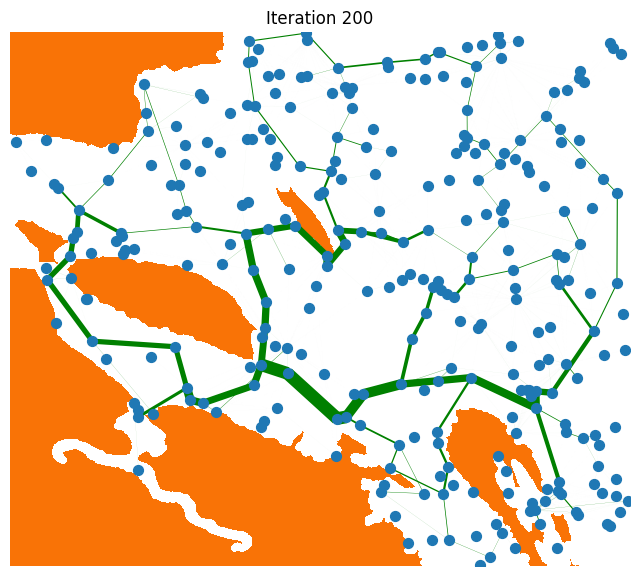

Iteration 200/1000 completed.


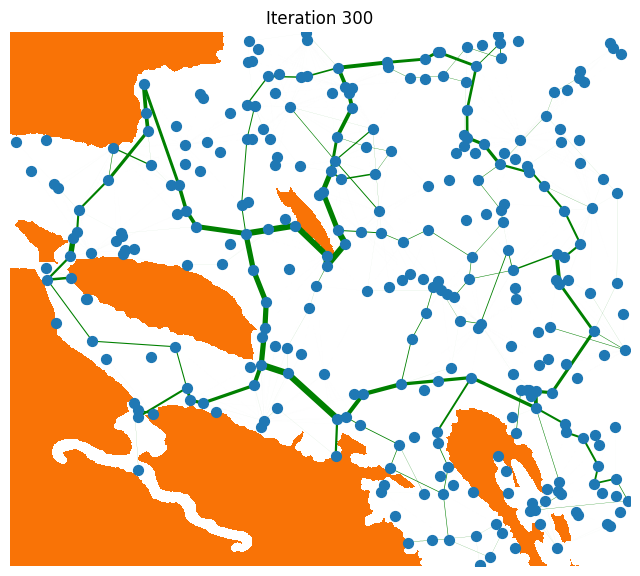

Iteration 300/1000 completed.


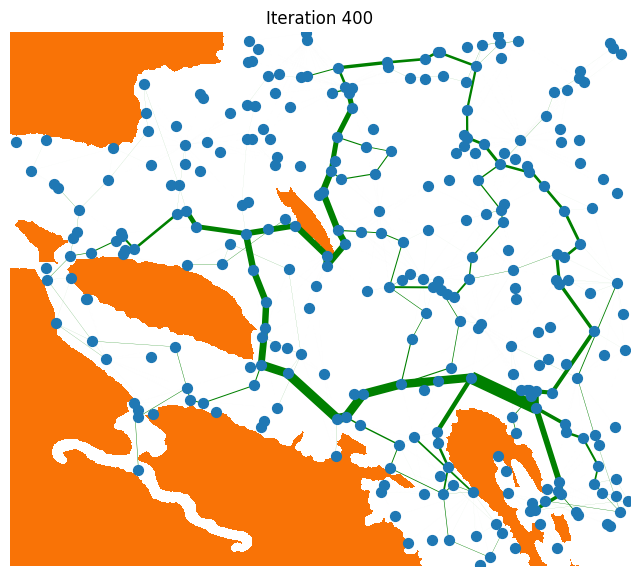

Iteration 400/1000 completed.


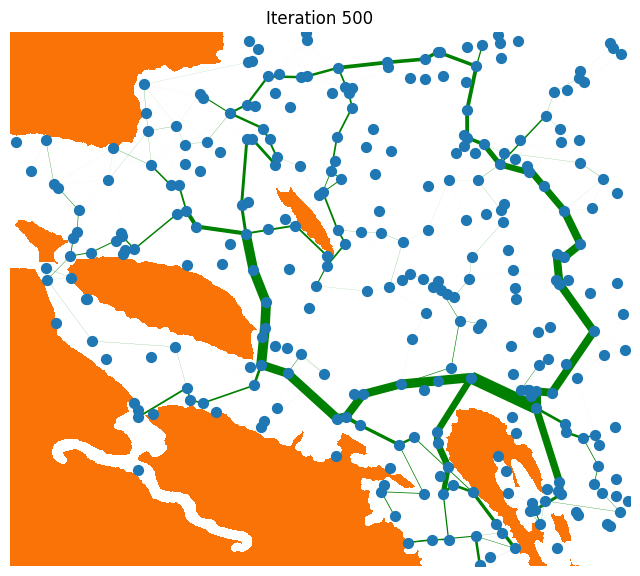

Iteration 500/1000 completed.


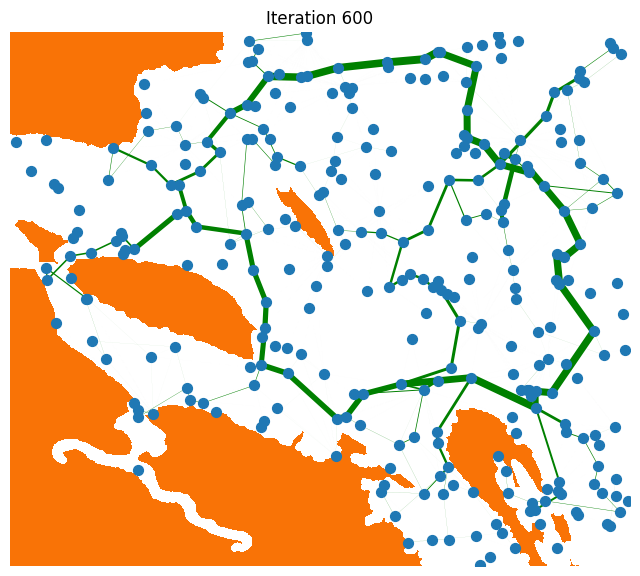

Iteration 600/1000 completed.


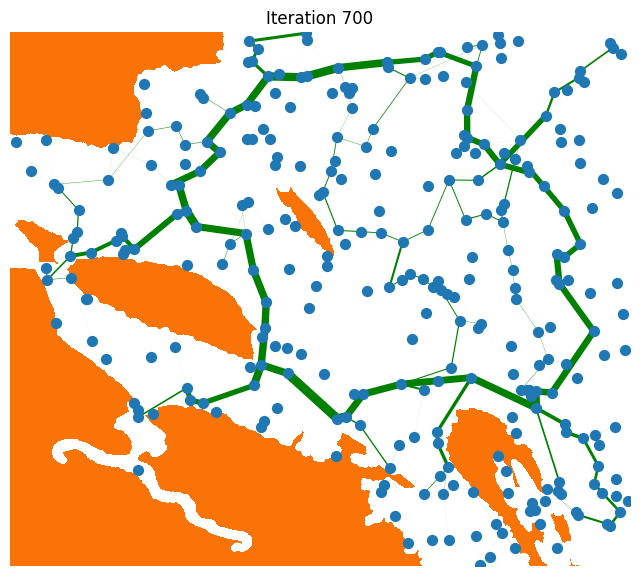

Iteration 700/1000 completed.


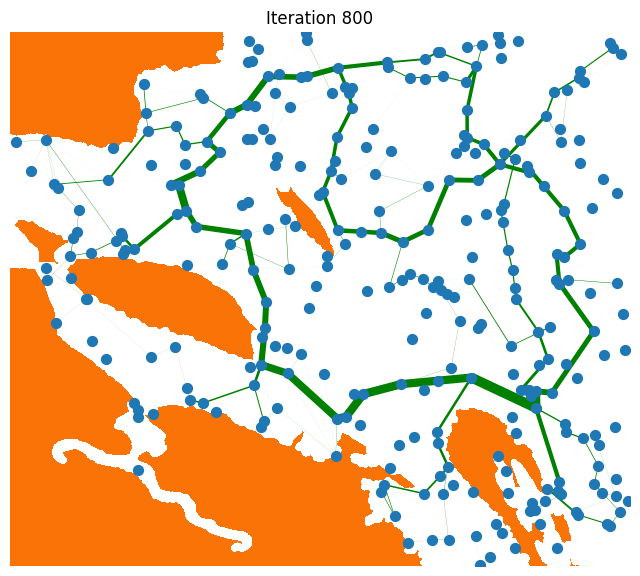

Iteration 800/1000 completed.


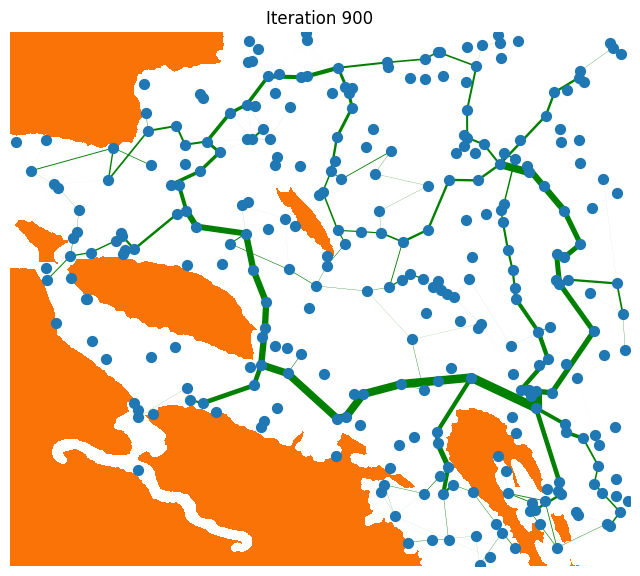

Iteration 900/1000 completed.


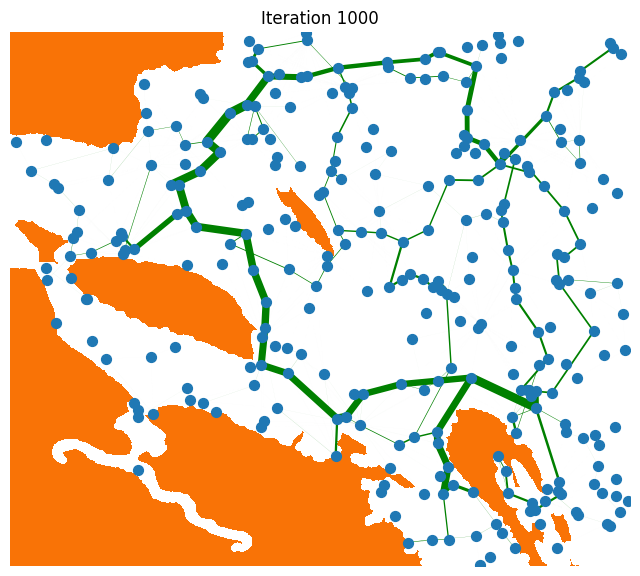

Iteration 1000/1000 completed.
Simulation completed.
Skipping simulation in subgraph - Num Nodes < 5 ...
Skipping simulation in subgraph - Num Nodes < 5 ...
Skipping simulation in subgraph - Num Nodes < 5 ...


In [60]:
ch_hist, generated_subgraphs = run_mold_simulation(G2, node_coordiantes2,inverse_node_positions2, restriction_map, restriction_cmap, 1.0, 2.0, 0.1, 1000, 50)

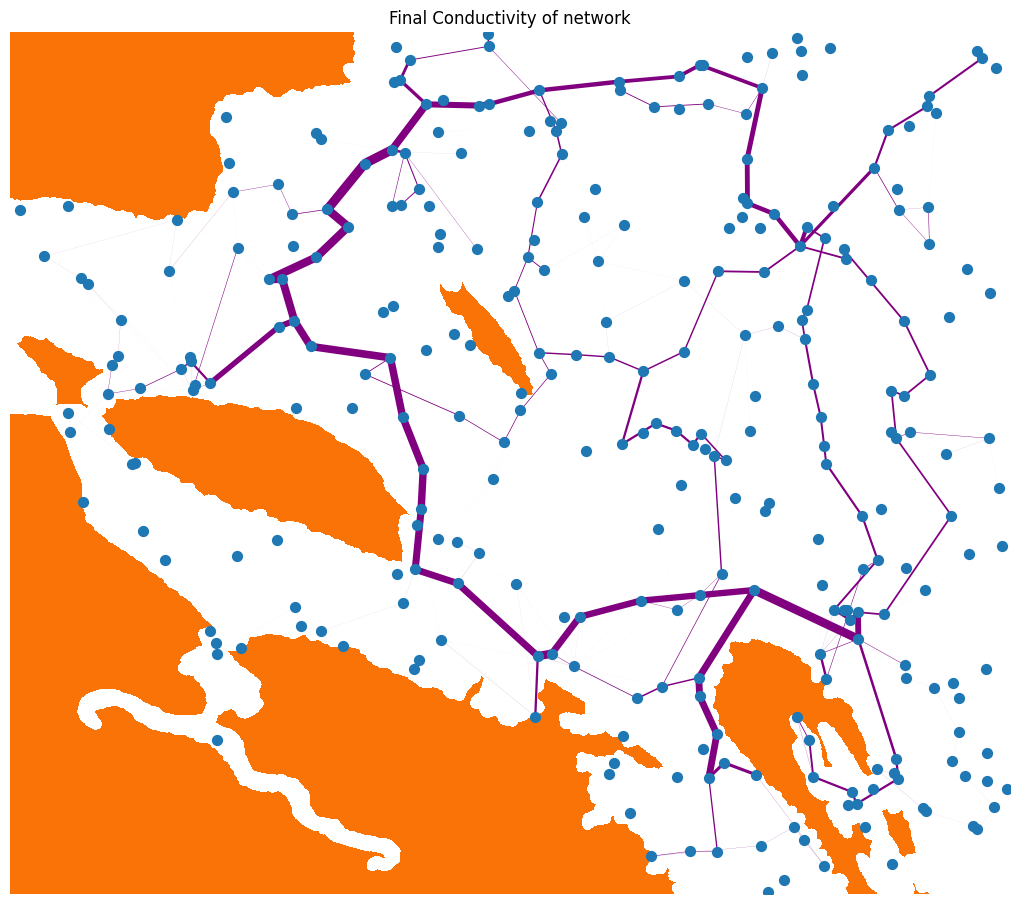

In [67]:
render_final_network(generated_subgraphs, inverse_node_positions2,  restriction_map, restriction_cmap)

# <font color='darkorange'><b> MODEL v2 </b> <font color='darkorange'>


## <font color='darkpurple'> <b>_IDENTIFIED CHALLENGE:_</b> </font>
Challenge - Images should have a matching - or closest as possible - workspace. The following image shows how caluclations may not be be accurate if dimensions and postions do not match between images and layers.

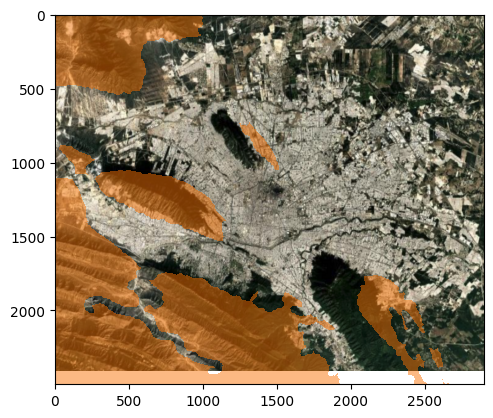

In [72]:
from PIL import Image
img = np.asarray(Image.open('MTY.png'))
plt.imshow(img)
plt.imshow(restriction_map, cmap=restriction_cmap, alpha = 0.5)


## <font color='darkpurple'> <b>_Methods for seeds generation using an image:_</b> </font>
- This process has the following steps:
  1. Generating a grayscale image from the orignal image - morphomogical transaformation can be applied if needed.
  2. Blob detection using the grayscale image
  3. Generating nodes from the obtained blobs.

### <font color='darkblue'> <b>Necessary Imports:</b> </font>

In [315]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import cv2

### <font color='darkblue'>
<b> morpholocial_preprocessing_to_grayscale() </b> </br>
Method for pre processing of original image to grayscale </b> </font>
- Method parameters:
  - __image__ : Image to be processed
  - __method__ : Valid methods are NONE (just grayscale), EROSION, DILATION, OPENING, CLOSING
  - __kernel_size__ : Kernel base (will be a square window of size kernel x kernel)
  - __iterations__ : Number of iterations (erosion and dilation)
  - __graph_result__ : If true, the four transformed versions are dispalyed to compare if the choosen transformation is the best

- Method outputs:
  - __an_image__ : Returns the imge processed using the given specifications

In [316]:
def morpholocial_preprocessing_to_grayscale(image, method, kernel_size, iterations,  graph_result = False):
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #genrate grayscale image
  kernel = np.ones((kernel_size, kernel_size), np.uint8) #deifne kernel size

  eroded  = cv2.erode(image_gray, kernel, iterations)
  dilated = cv2.dilate(image_gray, kernel, iterations)
  opening = cv2.morphologyEx(image_gray, cv2.MORPH_OPEN, kernel)
  closing = cv2.morphologyEx(image_gray, cv2.MORPH_CLOSE, kernel)

  if(graph_result is True):
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(7, 7))

    # Plot the Dilated Image
    axs[0,0].imshow(dilated, cmap='Greys')
    axs[0,0].set_title('Dilated Image')
    axs[0,0].set_xticks([])
    axs[0,0].set_yticks([])

    # Plot the Eroded Image
    axs[0,1].imshow(eroded, cmap='Greys')
    axs[0,1].set_title('Eroded Image')
    axs[0,1].set_xticks([])
    axs[0,1].set_yticks([])

    # Plot the opening (erosion followed by dilation)
    axs[1,0].imshow(opening, cmap='Greys')
    axs[1,0].set_title('Opening')
    axs[1,0].set_xticks([])
    axs[1,0].set_yticks([])

    # Plot the closing (dilation followed by erosion)
    axs[1,1].imshow(closing, cmap='Greys')
    axs[1,1].set_title('Closing')
    axs[1,1].set_xticks([])
    axs[1,1].set_yticks([])

    # Display the subplots
    plt.tight_layout()
    plt.show()

  if(method == 'EROSION'):
    return eroded
  if(method == 'DILATION'):
    return dilated
  if(method == 'OPENING'):
    return opening
  if(method == 'CLOSING'):
    return closing
  if(method == 'NONE'):
    return image_gray

### <font color='darkblue'>
<b> blob_identification_for_seeds() </b> </br>
Method to obtain blobs from a grayscale image and the determinant of hessian as it turned out to be the faster method by a significant degree. </b> </font>
- Method parameters:
  - __img__ : Image to be processed
  - __max_sigma_value__ : max sigma value for calculation of determinant of hessian
  - __threshold_value__ : threshold value for calculation of determinant of hessian
  - __graph_result__ : If true, the resulting blobs are graphed against the image

- Method outputs:
  - __blobs__ : Returns the blobs identified in the image
  
- **Note:** Refer to the followind link for documentation
  https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html

In [313]:
def blob_identification_for_seeds(img, max_sigma_value = 50, threshold_value = 0.0125, graph_result = False):
  blobs = blob_doh(img, max_sigma_value, threshold_value)

  if(graph_result is True):
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap='Greys')
    plt.title('Blobs')
    for blob in blobs:
      y, x, r = blob
      plt.scatter(x, y, color='cyan', s=20)
    plt.show()

  return blobs

### <font color='darkblue'> <b> Example preporcessing and blob identificaiton </b> </font>

In [317]:
image = np.asarray(Image.open('Zones_a.png'))

In [318]:
preprocessed_img = morpholocial_preprocessing_to_grayscale(image,'OPENING', 3, 2)

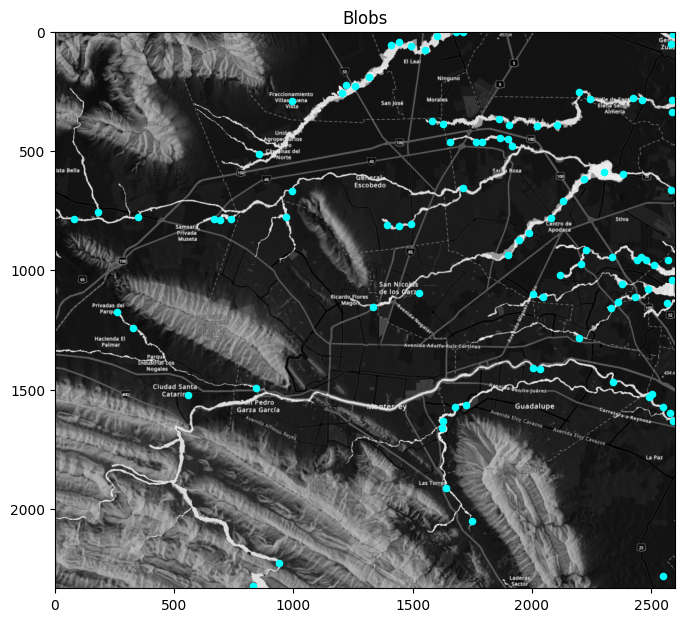

In [319]:
blobs = blob_identification_for_seeds(preprocessed_img, 100, 0.00125, True)

## <font color='darkpurple'> <b>_Generate nodes and graph using blobs as seeds:_</b> </font>
- This process has the following steps:
  1. Generating nodes from blob coordinates
  2. Add random or gaussian nodes in addition to the seeds
  3. Generating graph using both collection of nodes.

### <font color='darkblue'><b> generate_nodes_from_seeds() </b> </font>
- Method parameters:
  - __img__ : Image to be processed
  - __max_sigma_value__ : max sigma value for calculation of determinant of hessian
  - __threshold_value__ : threshold value for calculation of determinant of hessian
  - __graph_result__ : If true, the resulting blobs are graphed against the image

- Method outputs:
  - __blobs__ : Returns the blobs identified in the image
  
- **Note:** Refer to the followind link for documentation
  https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html

In [320]:
def generate_nodes_from_seeds(blobs, restriction_map, latitude, longitude):
    # Dictionary to hold nodes # and its position within the workspace
    node_positions = {}
    print(f"Generating nodes for {len(blobs)} blobs")
    iterator =0
    for blob in blobs:
      y_blob, x_blob, r = blob
      point = Point(y_blob, x_blob)
      # Validate the point does not fall into a restricted area
      if(x_blob < latitude) and (y_blob < longitude) :
        if not (contains(restriction_map, point)) :
          #print(iterator)
          node_positions[iterator] = (y_blob, x_blob)
          iterator += 1
    return node_positions

In [321]:
def set_working_graph_from_blobs(blobs, restriction_map, k, lat, lon):
  coords = generate_nodes_from_seeds(blobs, restriction_map, lat, lon)

  G = nx.Graph()
  # add our generated positions to the graph
  G.add_nodes_from(coords.keys())

  connect_k_closest_nodes(G, coords, k, restriction_map)
  initialize_conductivity_longitude(G, coords)
  inverted_pos = generate_inverted_positions(coords)
  return G, coords, inverted_pos

In [207]:
# Provide the number of desired nodes
# Provide the restriction map (boolean map) - This can be enhanced to support multiple restriction maps
# Provide coordiante limits for nodes generation, minimum and maximum latitude and longitudes.

# Method will return the graph and a dictonary containing the coordinates of each node.

def generate_graph_from_blobs(blobs, restriction_map, latitude, longitude):
    # Dictionary to hold node # and its position within the workspace
    node_positions = {}
    print(f"Generating graph from {len(blobs)} blobs")
    iterator =0
    for blob in blobs:
      y_blob, x_blob, r = blob
      point = Point(y_blob, x_blob)
      # Validate the point does not fall into a restricted area
      if(x_blob < latitude) and (y_blob < longitude) :
        if not (contains(restriction_map, point)) :
          #print(iterator)
          node_positions[iterator] = (y_blob, x_blob)
          iterator += 1

    # Create empty graph.
    G = nx.Graph()
    # add our generated positions to the graph
    G.add_nodes_from(node_positions.keys())

    return G , node_positions

In [209]:
G3, node_coordiantes3, inverse_node_positions3 = set_working_graph_from_blobs(blobs, restriction_map, 25, workspace_latitude, workspace_longitude)

Generating graph from 96 blobs


In [213]:
ch_hist3, generated_subgraphs3 = run_mold_simulation(G3, node_coordiantes3, inverse_node_positions3, restriction_map, restriction_cmap, 1.0, 2.0, 0.1, 1000, 50, False)

Generated 1 subgraphs.
Starting simulation in subgraph...
Iteration 100/1000 completed.
Iteration 200/1000 completed.
Iteration 300/1000 completed.
Iteration 400/1000 completed.
Iteration 500/1000 completed.
Iteration 600/1000 completed.
Iteration 700/1000 completed.
Iteration 800/1000 completed.
Iteration 900/1000 completed.
Iteration 1000/1000 completed.
Simulation completed.


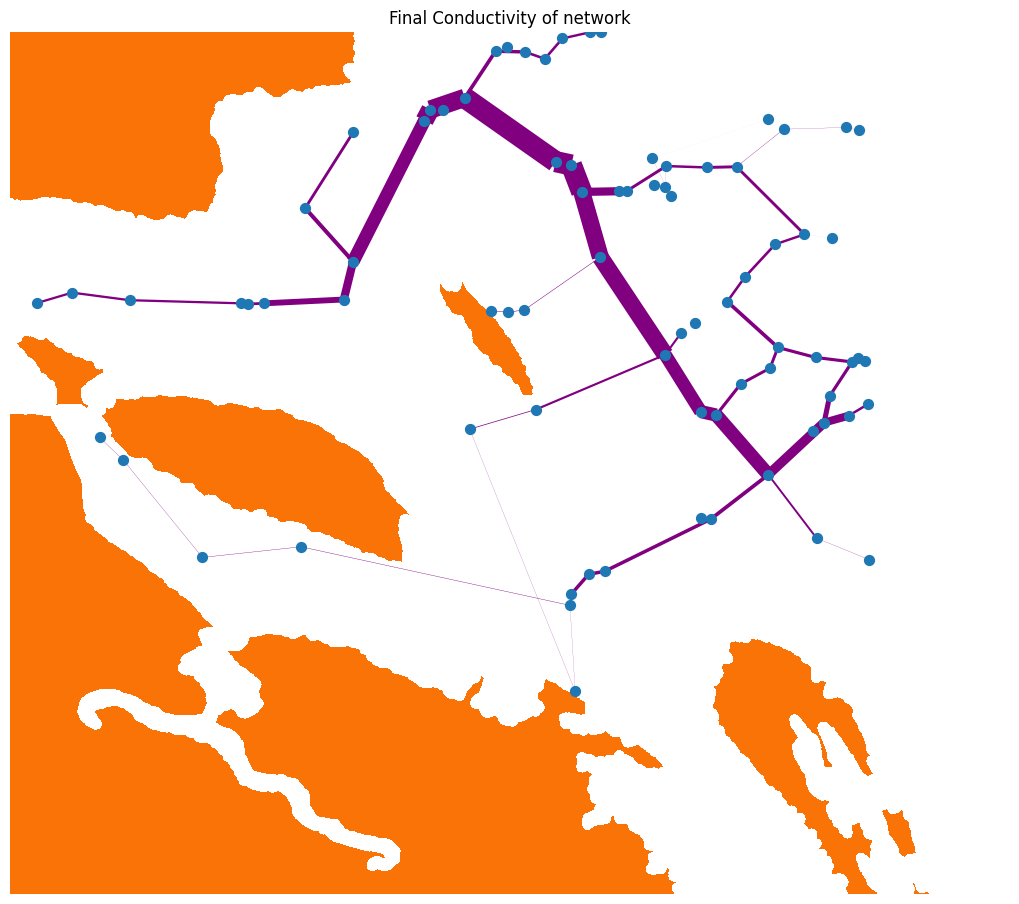

In [215]:
render_final_network(generated_subgraphs3, inverse_node_positions3, restriction_map, restriction_cmap)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

def animate(i):
    ax.clear()
    edge_widths = []
    num_subgraphs = len(generated_subgraphs3)

    # Render map with restricted areas
    plt.imshow(boolean_map, cmap=cmap_elevation_mask)

    for iter in range(num_subgraphs):
      ch = ch_hist[iter]
      S = generated_subgraphs3[iter]
      if(len(ch)> 1):
        edge_widths = [ch[i][idx] * 15 for idx in range(len(S.edges()))]
        nx.draw(S, pos=inverse_node_positions3, ax=ax, node_size=50, width=edge_widths, with_labels=False, edge_color='deeppink')

    ax.set_title(f'Iteración {i * 10}')
    plt.ylim(workspace_latitude, 0)
    plt.xlim(0, workspace_longitude)
    ax.axis('off')

# Create aniamtion - each frame represents progress every n iterations - like it was saved in the calcualting method
ani = animation.FuncAnimation(fig, animate, frames=len(ch_hist[0]), interval=500, repeat=False)

# Load animation in notebook
HTML(ani.to_jshtml())

In [248]:
def expand_from_seeds(seeds, desired_satellites, sigma_base, radius_mean):
  mean = np.array([radius_mean,radius_mean])
  sigma = np.array([sigma_base,sigma_base])
  covariance = np.diag(sigma ** 2)
  samples = np.random.multivariate_normal(mean, covariance, desired_satellites)

  x = samples[:, 0]  # Get the first column (x coordinates)
  y = samples[:, 1]  # Get the second column (y coordinates)

  fig, ax = plt.subplots()
  ax.plot(x, y, '.')
  fig.show()